# Pattern Recognition 3 - Points and Neighbourhoods

**Objectives**:

* Detect points of interest in an image
* Extract neighbourhood descriptors
* Use descriptors for clustering and matching

## Points of interest

In the previous labs, we have analyzed the images either using "object descriptors" (area, eccentricity, moments of segmented object) or "image descriptors" (based on all the pixels of the image). Another way of approaching an image analysis problem is to first look for "interesting points".

What makes a point *interesting* will highly depend on the application. Common examples are **corners**, or **local extrema**.

Starting from the `mitosis.bmp` image, find or create a **point detector** that will detect the nuclei of the cells.

> *Hint: it may be easier to do so in a different color space...*

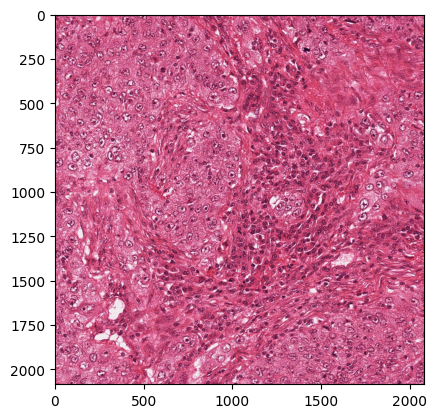

In [43]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread

im = imread('mitosis.bmp')
plt.figure()
plt.imshow(im)
plt.show()

<Figure size 640x480 with 0 Axes>

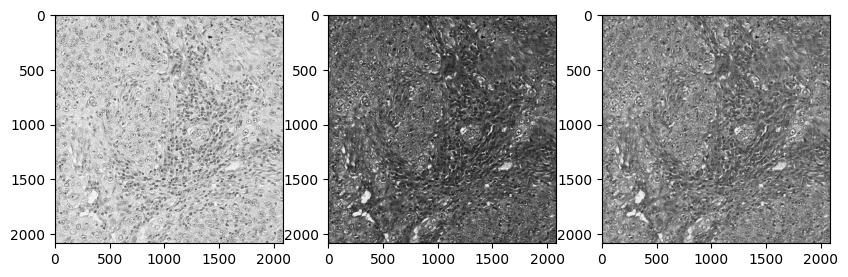

In [44]:
# explore possibilities with color channels
plt.gray()
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(im[:, :, 0])
plt.subplot(132)
plt.imshow(im[:, :, 1])
plt.subplot(133)
plt.imshow(im[:, :, 2])
plt.show()



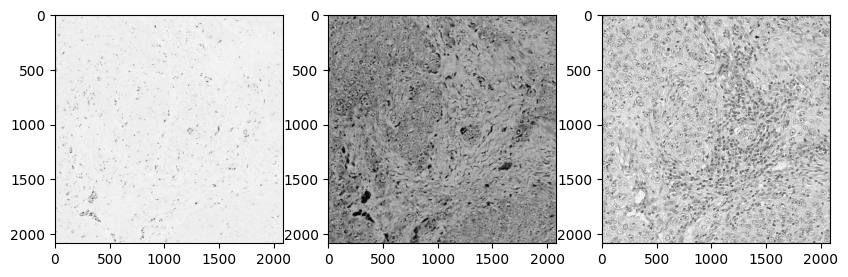

In [45]:
from skimage.color import rgb2hsv
hsv = rgb2hsv(im) # crop image with im[500:1000, 500:1000, :]
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(hsv[:, :, 0])
plt.subplot(132)
plt.imshow(hsv[:, :, 1])
plt.subplot(133)
plt.imshow(hsv[:, :, 2])
plt.show()


We will use the value channel from the HSV (or red channel from RGB). It will help to segment the image and to find the nuclei of the cells.

Now we can find blobs in the image. Blobs are bright on dark or dark on bright regions in an image

(7004, 3)


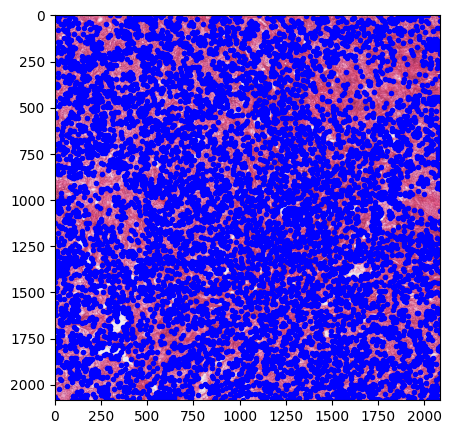

In [46]:
from skimage.feature import blob_log

# find blobs in the image
blobs = blob_log(1-hsv[:,:,2], min_sigma = 4, max_sigma=10, threshold=0.1)
print(blobs.shape)

plt.figure(figsize=(10, 5))
plt.imshow(im)
plt.plot(blobs[:, 1], blobs[:, 0], 'b.', alpha=1)
plt.show()

We can also look for corners in the image (but there are no corners apparent, so we don't try it). Another thing is to look for the local peaks.

(2495, 2)


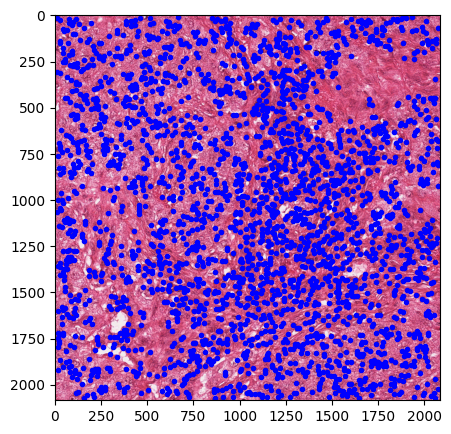

In [47]:
# local peak detection
from skimage.feature import peak_local_max

plm = peak_local_max(1-hsv[:,:,2], min_distance=10, threshold_rel=0.7)
print(plm.shape)
plt.figure(figsize=(10, 5))
plt.imshow(im)
plt.plot(plm[:, 1], plm[:, 0], 'b.', alpha=1)
plt.show()

## Descriptors

The goal of *descriptors* is to represent the region surrounding the point of interest in a way that allow our algorithm to best perform its task. For instance, the BRIEF descriptor will compare pairs of pixels in the given neighbourhood and create a binary descriptor representing the result of all these comparison. This kind of descriptor will tend to create a unique signature in a grayscale image, and is very useful for applications such as matching for stereo-vision or for video tracking.

Other types of descriptors can be based on the texture (for instance with local Fourier transforms) or on local histograms.

* Using the points detected before, **extract neighbourhood patches** and **compute the concatenated color histogram** as a descriptor (meaning a 256+256+256 = size 768 vector, with the first 256 values corresponding to the R histogram, etc...).
* Use the [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class from `scikit-learn` to cluster the points of interest depending on their descriptor. Can you identify clusters representing the type of tissue of the cell?

In [48]:
from sklearn.cluster import KMeans

def compute_histogram(patch):
    rgb_histogram = np.zeros((768,))
    
    for v in range(256):
        rgb_histogram[v] = np.sum(patch[:, :, 0] == v)
        rgb_histogram[v + 256] = np.sum(patch[:, :, 1] == v)
        rgb_histogram[v + 512] = np.sum(patch[:, :, 2] == v)
    
    return rgb_histogram

def extract_descriptors(im, coords, neighbourhood_size=15):
    ## compute histogram and compile everything in a "descriptor matrix"
    descriptors = []
    for row,col in coords:
        region = im[row-neighbourhood_size//2:row+neighbourhood_size//2,col-neighbourhood_size//2:col+neighbourhood_size//2]
        descriptors.append(compute_histogram(region))

    return np.array(descriptors)

descriptors = extract_descriptors(im, plm)
print(descriptors.shape)

(2495, 768)


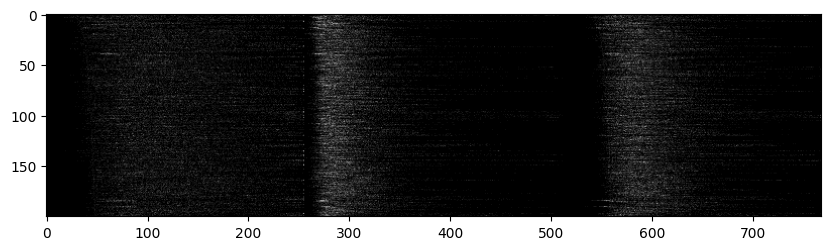

In [49]:
plt.figure(figsize=(10, 5))
plt.imshow(descriptors[:200])

In [50]:
km = KMeans(n_clusters=2, random_state=0) #we want 2 clusters for the cells and the other region
km.fit(descriptors)

KMeans(n_clusters=2, random_state=0)

1401 1094


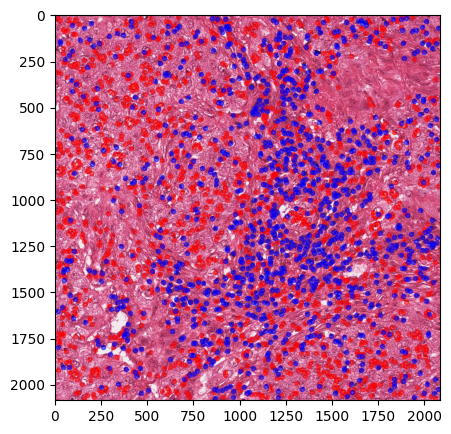

In [51]:
clusters = km.predict(descriptors)
print((clusters == 0).sum(), (clusters == 1).sum())
plt.figure(figsize=(10, 5))
plt.imshow(im)
plt.plot(plm[clusters == 0, 1], plm[clusters == 0, 0], 'r.', alpha=0.5)
plt.plot(plm[clusters == 1, 1], plm[clusters == 1, 0], 'b.', alpha=0.5)
plt.show()

* Apply the same point detection and descriptors on the `mitosis2.bmp` image, and use the already trained KMeans to predict the clusters of the points in the new image.

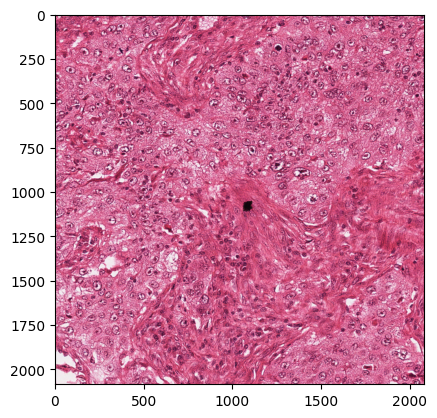

In [52]:
im2 = imread('mitosis2.bmp')
plt.figure()
plt.imshow(im2)
plt.show()

In [54]:
hsv2 = rgb2hsv(im2)
plm2 = peak_local_max(1-hsv2[:,:,2], min_distance=10, threshold_rel=0.5)
print(plm2.shape)
descriptors2 = extract_descriptors(im2, plm2)
print(descriptors.shape)

(4691, 2)
(2495, 768)


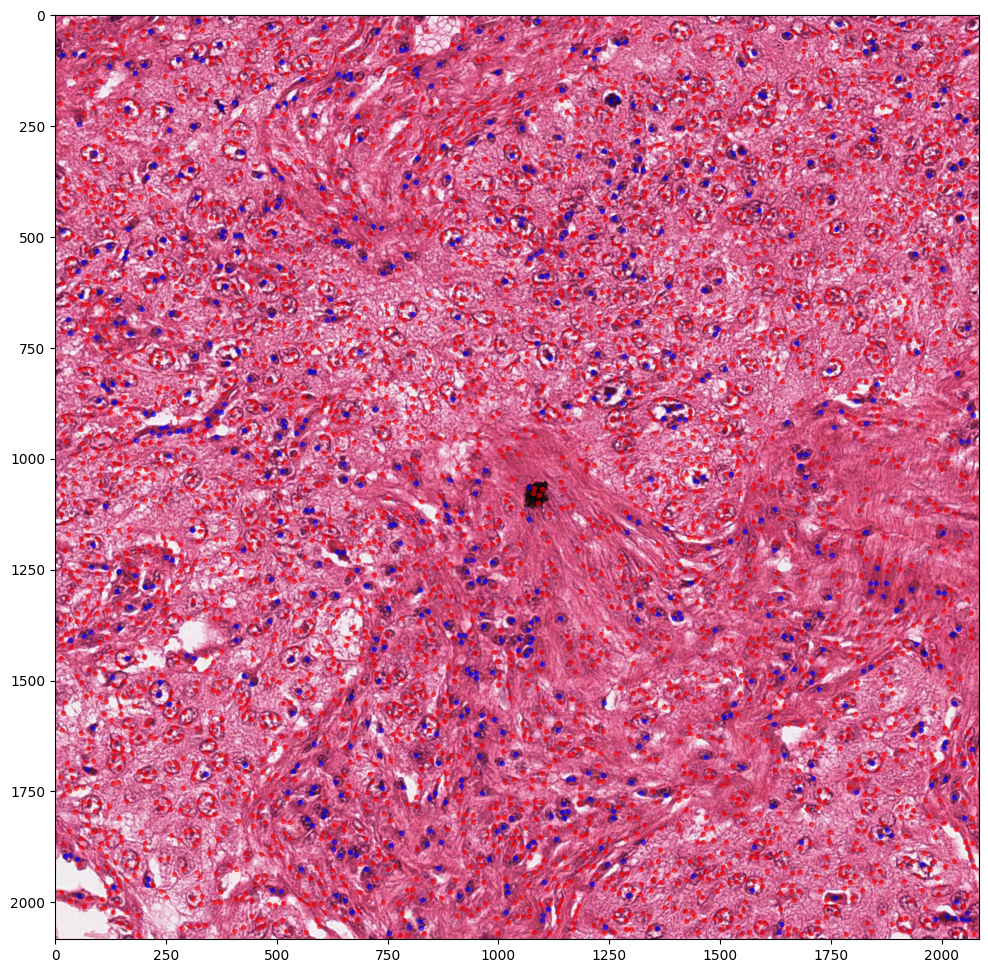

In [57]:
clusters2 = km.predict(descriptors2)
plt.figure(figsize=(12, 12))
plt.imshow(im2)
plt.plot(plm2[clusters2 == 0, 1], plm2[clusters2 == 0, 0], 'r.', alpha=0.5)
plt.plot(plm2[clusters2 == 1, 1], plm2[clusters2 == 1, 0], 'b.', alpha=0.5)
plt.show()

In conclusion, we see that it's possible to do something even if it's not perfect.